# Loan Prediction - Student, Credit card, Conventional Loan

**Things to keep in mind while engineering**

check profitability, measure risk free rate --> canadian interest rate --> 0.18%

check if expected value of that loan is better than the risk free rate

challenges: finding a reasonable way to calculate the chance of default and pricing interest rates without market data (with market data, could base it off of market price)

**Feature Breakdowns**

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/Female --> (0/1)|
|Married| Applicant married (Y/N) --> (0/1)|
|Dependents| Number of dependents  --> (0/1/2/3)|
|Education| Applicant Education (Graduate/ Under Graduate) --> (0/1)|
|Self_Employed| Self employed (Y/N) --> (0/1)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands of dollars|
|Loan_Amount_Term| Term of loan in years|
|Credit_History| credit history meets guidelines  --> (0/1)|
|min_loan| the smallest profitable loan calculated with the risk free rate|
|TotalIncome| Applicant + Coapplicant income|
|Loan_Interest| Time breakdown for interest calculation --> (1/2/3)|
|RiskFreeRate(%)| Canada's risk free rate on 11/20/2021|
|STATUS| Payment status of the loan|
|Default| Scale to measure how recently the loan has been paid/been unpaid --> (1/2/3/4/5)|
|Con_Loan_Interest(%)| The amount of interest required for a conventional loan, calculated using loan_interest (time interval), current treasury bill yields and market average starting interest rate|
|Student_Loan_Interest(%)| The current market average student loan interest rate|
|Credit_Loan_Interest(%)| The current market average credit card loan interest rate|
|Con_Loan_Interest_Payment| Dollar value of convential loan interest at the end of the term|
|Credit_Loan_Interest_Payment| Dollar value of credit card loan interest at the end of the term|
|Student_Loan_Interest_Payment| Dollar value of credit card loan interest at the end of the term ($0)|

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import sklearn.model_selection as model_selection
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing

In [3]:
# import datasets
app_rec = pd.read_csv(r"data\application_record.csv")
cred_rec = pd.read_csv(r"data\credit_record.csv")
test_ConLoan = pd.read_csv(r"data\test_ConLoan.csv")
train_ConLoan = pd.read_csv(r"data\train_ConLoan.csv")
ConLoan = pd.read_csv(r"data\ConLoanData.csv")

In [4]:
# combine datasets
General_Loan_df = test_ConLoan.append(train_ConLoan)

In [5]:
General_Loan_df = General_Loan_df.append(ConLoan)

In [6]:
data = General_Loan_df

### Checking for and replacing missing values

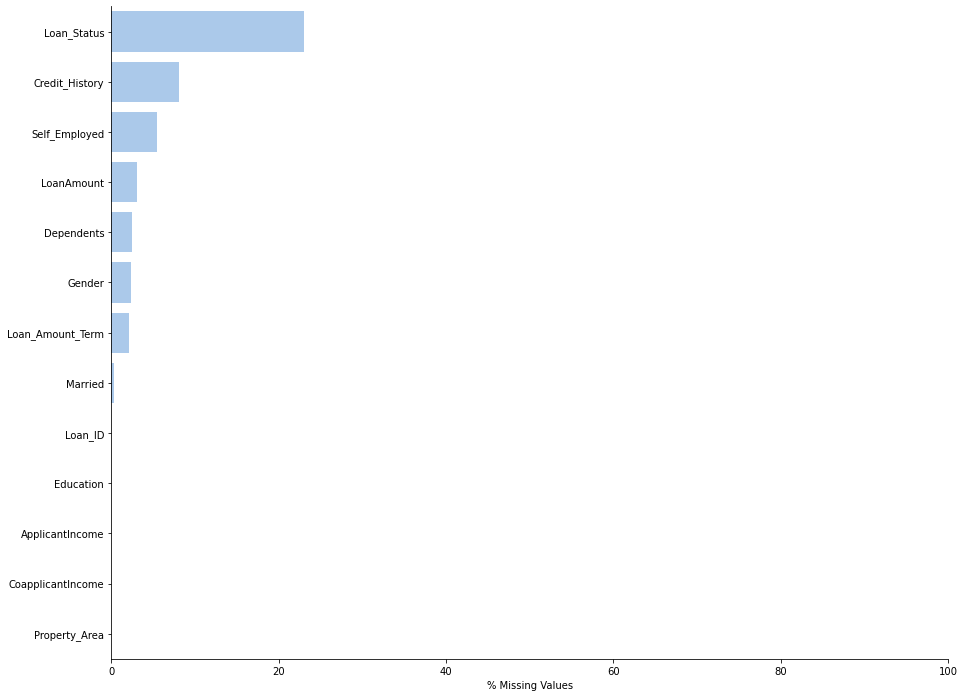

In [7]:
#plotting the percentage of missing values in each column
data_length = len(data)
data_null = (data.isnull().sum().sort_values(ascending=False)*100/len(data))
f, ax = plt.subplots(figsize=(15, 12))
sns.set_color_codes("pastel")
sns.set_color_codes("pastel")
ax.set(xlim=(0, 100), ylabel="",
       xlabel="% Missing Values")
sns.barplot(x=data_null.values, y=data_null.index, color="b")
sns.despine()

In [8]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

display(missing_data)
display(data.shape)

,Total,Percent
Loan_Status,367,0.230094
Credit_History,129,0.080878
Self_Employed,87,0.054545
LoanAmount,49,0.030721
Dependents,40,0.025078
Gender,37,0.023197
Loan_Amount_Term,34,0.021317
Married,6,0.003762
Loan_ID,0,0.000000
Education,0,0.000000


(1595, 13)

In [9]:
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)
data = data.drop(["Property_Area"],axis = 1)
data = data.dropna()

In [10]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

display(missing_data.head(13))
display(data.shape)

,Total,Percent
Loan_ID,0,0.0
Gender,0,0.0
Married,0,0.0
Dependents,0,0.0
Education,0,0.0
Self_Employed,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0
LoanAmount,0,0.0
Loan_Amount_Term,0,0.0


(998, 12)

### Label Encoding

In [11]:
category= ['Gender','Married','Dependents','Education','Self_Employed','Loan_Status'] 
encoder= LabelEncoder()
for i in category:   
  data[i] = encoder.fit_transform(data[i]) 
  data.dtypes

## Feature engineering

### Design feature to determine loan interest based off of term lengths
1 --> loans sub 180 days\
2 --> loans between 180-359 days\
3 --> loans above 359 days

In [12]:
conditions = [
    (data['Loan_Amount_Term'] < 180),
    (data['Loan_Amount_Term'] >= 180) & (data['Loan_Amount_Term'] < 360),
    (data['Loan_Amount_Term'] >= 360) 
    ]

values = ['1', '2', '3']

data['Loan_Interest'] = np.select(conditions, values)

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest
0,LP001002,1,0,0,0,0,5849,0.0,144.005175,360.0,1.0,1,3
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,3
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,1,3
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,1,3
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,1,3


### Add risk free rate and reset index

In [13]:
data = data.astype({'LoanAmount': 'int64'})
data = data.astype({'Loan_Status': 'int64'})
data['RiskFreeRate(%)'] = '0.018'
data = data.reset_index(drop=True)
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%)
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,LP002978,0,0,0,0,0,2900,0.0,71,360.0,1.0,1,3,0.018
994,LP002979,1,1,3,0,0,4106,0.0,40,180.0,1.0,1,2,0.018
995,LP002983,1,1,1,0,0,8072,240.0,253,360.0,1.0,1,3,0.018
996,LP002984,1,1,2,0,0,7583,0.0,187,360.0,1.0,1,3,0.018


### Grab and combine default/payment status's with the main dataset

In [14]:
cred_rec = cred_rec.iloc[::1050, :]
cred_rec = cred_rec.iloc[1: , :]
cred_rec = cred_rec.drop(["ID","MONTHS_BALANCE"],axis = 1)
cred_rec = cred_rec.reset_index(drop=True)

In [15]:
data = pd.concat([data, cred_rec], axis=1, join='inner')
display(data)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,LP002978,0,0,0,0,0,2900,0.0,71,360.0,1.0,1,3,0.018,C
994,LP002979,1,1,3,0,0,4106,0.0,40,180.0,1.0,1,2,0.018,C
995,LP002983,1,1,1,0,0,8072,240.0,253,360.0,1.0,1,3,0.018,C
996,LP002984,1,1,2,0,0,7583,0.0,187,360.0,1.0,1,3,0.018,0


In [16]:
data.STATUS.apply(str)

0      C
1      X
2      X
3      C
4      X
      ..
993    C
994    C
995    C
996    0
997    C
Name: STATUS, Length: 998, dtype: object

### Create Default loan values based off of loan repayment status
2 --> cannot get loans, they are close to or have defaulted\
1 --> should pay bills\
0 --> no problems

In [17]:
conditions = [
    (data['STATUS'] == 'X'),
    (data['STATUS'] == '5'),
    (data['STATUS'] == '4'),
    (data['STATUS'] == '3'),
    (data['STATUS'] == '2'),
    (data['STATUS'] == '1')
    ]

values = ['2', '2', '1', '1', '0', '0']

data['Default'] = np.select(conditions, values)

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS,Default
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C,0
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X,2
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X,2
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C,0
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X,2


**NOTE: Dataset of approx 1000 rows, approx 20% of loans taken by students are defaulted, according to US Dep. of Education**

<AxesSubplot:xlabel='Default', ylabel='Count'>

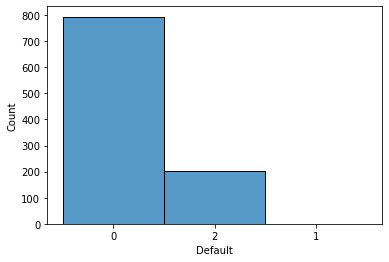

In [18]:
sns.histplot(data['Default'])

### Design Convential Loan Interest % 
Designed using the market average interest for loans, based off of how long each term is, the interest rate goes up in accordance with the return rate of its treasury bill counterpart\
Made assumptions of the interest rate to make sure its profitable

In [19]:
conditions = [
    (data['Loan_Interest'] == '3'),
    (data['Loan_Interest'] == '2'),
    (data['Loan_Interest'] == '1')
    ]

a=2.45 #market average convential loan interest
b=2.45 + 0.44 #3 month annual T-bill
c=2.45 + 0.71 #1 year annual T-bill

values = ['3.16','2.89','2.45']

data['Con_Loan_Interest(%)'] = np.select(conditions, values)

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS,Default,Con_Loan_Interest(%)
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C,0,3.16
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X,2,3.16
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X,2,3.16
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C,0,3.16
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X,2,3.16


<AxesSubplot:xlabel='Con_Loan_Interest(%)', ylabel='Count'>

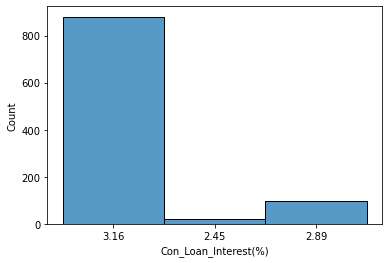

In [20]:
#check distribution
sns.histplot(data['Con_Loan_Interest(%)'])

In [21]:
data = data.astype({'Con_Loan_Interest(%)': 'float64'})

### Design 'Kelly Criterion' feature to optimize loan size for the company

In [22]:
# kelly crit optimizes the loan size to maximize gains overtime
data['KellyCrit(%)'] = 0.65 - (0.2 / data['Con_Loan_Interest(%)'])

### Design TotalIncome

In [23]:
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']

### Design Credit card loan interest rate and student loan interest rate
Credit card loans are taken as the market average\
Student loans are 0% in many parts of Canada, assumed to be 0%

In [24]:
data['Credit_Loan_Interest(%)'] = 0.22 # market average
data['Student_Loan_Interest(%)'] = 0 # market average 

### Engineered the total expected interest payment for all loan types 

In [25]:
data['Con_Loan_Interest_Payment'] = ((data['Con_Loan_Interest(%)']) * data['LoanAmount'])
data['Credit_Loan_Interest_Payment'] = ((data['Credit_Loan_Interest(%)']) * data['LoanAmount'])
data['Student_Loan_Interest_Payment'] = 0

In [26]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,STATUS,Default,Con_Loan_Interest(%),KellyCrit(%),TotalIncome,Credit_Loan_Interest(%),Student_Loan_Interest(%),Con_Loan_Interest_Payment,Credit_Loan_Interest_Payment,Student_Loan_Interest_Payment
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,...,C,0,3.16,0.586709,5849.0,0.22,0,455.04,31.68,0
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,...,X,2,3.16,0.586709,6091.0,0.22,0,404.48,28.16,0
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,...,X,2,3.16,0.586709,3000.0,0.22,0,208.56,14.52,0
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,...,C,0,3.16,0.586709,4941.0,0.22,0,379.20,26.40,0
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,...,X,2,3.16,0.586709,6000.0,0.22,0,445.56,31.02,0


In [27]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Loan_Interest',
       'RiskFreeRate(%)', 'STATUS', 'Default', 'Con_Loan_Interest(%)',
       'KellyCrit(%)', 'TotalIncome', 'Credit_Loan_Interest(%)',
       'Student_Loan_Interest(%)', 'Con_Loan_Interest_Payment',
       'Credit_Loan_Interest_Payment', 'Student_Loan_Interest_Payment'],
      dtype='object')

### Dividing the General Dataset up into loan types

In [28]:
#Convential loan
CON_LOAN_DATA = data.drop(['Credit_Loan_Interest(%)','Credit_Loan_Interest_Payment','Student_Loan_Interest_Payment','Student_Loan_Interest(%)'],axis = 1)

In [29]:
# save Convential loan dataset (including calories)
CON_LOAN_DATA.to_csv(r'data\CON_LOAN_DATA.csv', index=False)

In [30]:
# Student loan
STUDENT_LOAN_DATA = data.drop(['Credit_Loan_Interest(%)','Credit_Loan_Interest_Payment','Con_Loan_Interest(%)','Con_Loan_Interest_Payment'],axis = 1)

In [31]:
# save Student loan dataset (including calories)
STUDENT_LOAN_DATA.to_csv(r'data\STUDENT_LOAN_DATA.csv', index=False)

In [32]:
# Credit loan
CREDIT_LOAN_DATA = data.drop(['Con_Loan_Interest(%)','Con_Loan_Interest_Payment','Student_Loan_Interest_Payment','Student_Loan_Interest(%)'],axis = 1)

In [33]:
# save Credit loan dataset (including calories)
CREDIT_LOAN_DATA.to_csv(r'data\CREDIT_LOAN_DATA.csv', index=False)

# Credit Dataframe

### Load Datasets

In [34]:
cred_df = pd.read_csv(r"data\CREDIT_LOAN_DATA.csv")

### Engineer minimum loan

In [35]:
cred_df['min_loan'] = cred_df['TotalIncome'] * cred_df['RiskFreeRate(%)']

In [36]:
pd.set_option('display.max_columns', None)
cred_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS,Default,KellyCrit(%),TotalIncome,Credit_Loan_Interest(%),Credit_Loan_Interest_Payment,min_loan
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C,0,0.586709,5849.0,0.22,31.68,105.282
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X,2,0.586709,6091.0,0.22,28.16,109.638
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X,2,0.586709,3000.0,0.22,14.52,54.000
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C,0,0.586709,4941.0,0.22,26.40,88.938
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X,2,0.586709,6000.0,0.22,31.02,108.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,LP002978,0,0,0,0,0,2900,0.0,71,360.0,1.0,1,3,0.018,C,0,0.586709,2900.0,0.22,15.62,52.200
994,LP002979,1,1,3,0,0,4106,0.0,40,180.0,1.0,1,2,0.018,C,0,0.580796,4106.0,0.22,8.80,73.908
995,LP002983,1,1,1,0,0,8072,240.0,253,360.0,1.0,1,3,0.018,C,0,0.586709,8312.0,0.22,55.66,149.616
996,LP002984,1,1,2,0,0,7583,0.0,187,360.0,1.0,1,3,0.018,0,0,0.586709,7583.0,0.22,41.14,136.494


<AxesSubplot:xlabel='Loan_Status', ylabel='Count'>

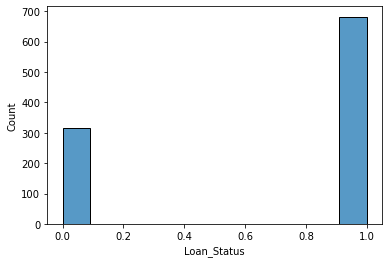

In [37]:
sns.histplot(cred_df['Loan_Status'])

# Building Predictive Models - Credit Loan

In [38]:
cred_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Loan_Interest',
       'RiskFreeRate(%)', 'STATUS', 'Default', 'KellyCrit(%)', 'TotalIncome',
       'Credit_Loan_Interest(%)', 'Credit_Loan_Interest_Payment', 'min_loan'],
      dtype='object')

In [39]:
#Assign train and target variables
X = cred_df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Interest','TotalIncome','Credit_Loan_Interest(%)', 'Credit_Loan_Interest_Payment', 'min_loan']]
y = cred_df['Loan_Status']

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

In [40]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Random_Forest_Model_CredLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.807
MAE Score for test data:  0.04


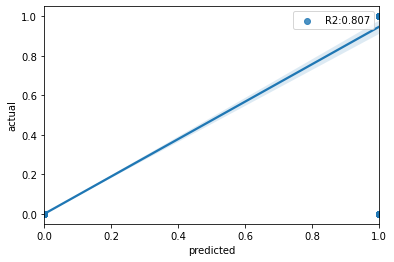

In [41]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

In [42]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [5,10,15,100,150,200,250],
    'criterion' : ['gini,', 'entropy'],
    'max_depth' : [0,5,8,10,12,15,18,20]
}

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

In [43]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 200}

0.9171096196868008

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
103,0.298078,0.004220,0.017770,0.000374,entropy,18,200,"{'criterion': 'entropy', 'max_depth': 18, 'n_e...",0.900000,0.94,0.913333,0.926174,0.906040,0.917110,0.014392,1
109,0.269160,0.061751,0.020105,0.012402,entropy,20,150,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.900000,0.94,0.913333,0.926174,0.899329,0.915767,0.015622,2
110,0.359145,0.053794,0.020207,0.002306,entropy,20,200,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.886667,0.94,0.920000,0.926174,0.899329,0.914434,0.019087,3


### Retrain model

In [44]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=20,criterion='entropy')

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Final_Random_Forest_Model_CredLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.768
MAE Score for test data:  0.05


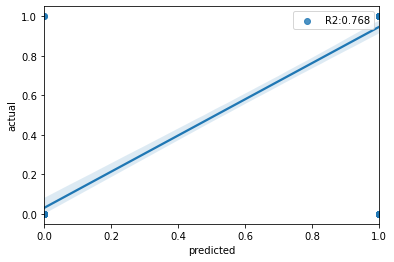

In [45]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

# CredLoan Pipeline

In [46]:
numeric_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Credit_Loan_Interest(%)','Credit_Loan_Interest_Payment','min_loan']
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

num_feats = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Credit_Loan_Interest(%)','Credit_Loan_Interest_Payment','min_loan']
cat_feats = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

In [47]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state = 42))
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
np.mean(preds == y_test)

0.96

In [48]:
fillna_step = ColumnTransformer([
    ('fillna_most_frequent', SimpleImputer(fill_value='missing',strategy="most_frequent"), cat_feats),
    ('fillna_mean', SimpleImputer(fill_value='missing',strategy="mean"), num_feats)
], remainder='passthrough')

from sklearn.preprocessing import OneHotEncoder
enc_cat = OneHotEncoder(handle_unknown='ignore', sparse=False)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

from sklearn.ensemble import GradientBoostingClassifier
model1 = RandomForestClassifier(n_estimators=100, max_depth=20,criterion='entropy')
pipeline = Pipeline(steps=[
    ('fillna_step',fillna_step),
    ('enc_cat',enc_cat),
    ('scaler',scaler),
    ('transformer',transformer),
    ('base_model',model1)
])
pipeline.fit(X,y)
pickle.dump(pipeline, open( "PipeRF_CredLoan.pkl", "wb" ) )

In [49]:
pipe = pipeline.fit(X, y)
print('Testing score: ', pipe.score(X, y))

Testing score:  0.8336673346693386


# Student Dataframe

In [50]:
stud_df = pd.read_csv(r"data\STUDENT_LOAN_DATA.csv")

### Engineer minimum loan

In [51]:
stud_df['min_loan'] = stud_df['TotalIncome'] * stud_df['RiskFreeRate(%)']

In [52]:
pd.set_option('display.max_columns', None)
stud_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS,Default,KellyCrit(%),TotalIncome,Student_Loan_Interest(%),Student_Loan_Interest_Payment,min_loan
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C,0,0.586709,5849.0,0,0,105.282
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X,2,0.586709,6091.0,0,0,109.638
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X,2,0.586709,3000.0,0,0,54.000
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C,0,0.586709,4941.0,0,0,88.938
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X,2,0.586709,6000.0,0,0,108.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,LP002978,0,0,0,0,0,2900,0.0,71,360.0,1.0,1,3,0.018,C,0,0.586709,2900.0,0,0,52.200
994,LP002979,1,1,3,0,0,4106,0.0,40,180.0,1.0,1,2,0.018,C,0,0.580796,4106.0,0,0,73.908
995,LP002983,1,1,1,0,0,8072,240.0,253,360.0,1.0,1,3,0.018,C,0,0.586709,8312.0,0,0,149.616
996,LP002984,1,1,2,0,0,7583,0.0,187,360.0,1.0,1,3,0.018,0,0,0.586709,7583.0,0,0,136.494


<AxesSubplot:xlabel='Loan_Status', ylabel='Count'>

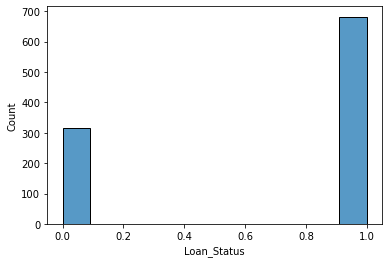

In [53]:
sns.histplot(stud_df['Loan_Status'])

# Building Predictive Models - Student Loan

In [54]:
#Assign train and target variables
X = stud_df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Interest','TotalIncome','Student_Loan_Interest(%)', 'Student_Loan_Interest_Payment', 'min_loan']]
y = stud_df['Loan_Status']

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

In [55]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Random_Forest_Model_StudLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.768
MAE Score for test data:  0.05


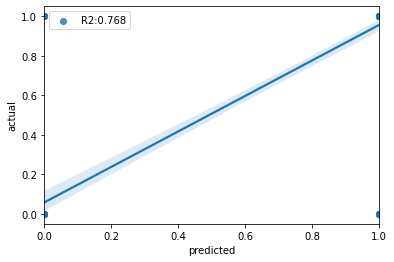

In [56]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

In [57]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [5,10,15,100,150,200,250],
    'criterion' : ['gini,', 'entropy'],
    'max_depth' : [5,8,10,12,15,18,20]
}

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.8021387  0.80748098 0.81548098 0.81816555 0.81416555
 0.81283221 0.81284116 0.83955257 0.83154362 0.83285011 0.84355257
 0.83687696 0.83687696 0.84089485 0.84891275 0.83958837 0.84489485
 0.85425503 0.85424609 0.8489217  0.85024609 0.8489217  0.87165101
 0.86765101 0.87564206 0.87699329 0.8796689  0

In [58]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 100}

0.922434004474273

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,0.156270,0.006556,0.010153,0.000478,entropy,18,100,"{'criterion': 'entropy', 'max_depth': 18, 'n_e...",0.920000,0.953333,0.913333,0.919463,0.90604,0.922434,0.016255,1
90,0.423699,0.019926,0.024697,0.001049,entropy,18,250,"{'criterion': 'entropy', 'max_depth': 18, 'n_e...",0.913333,0.953333,0.913333,0.919463,0.90604,0.921101,0.016668,2
97,0.417280,0.007333,0.027531,0.000737,entropy,20,250,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.906667,0.953333,0.920000,0.912752,0.90604,0.919758,0.017527,3


## Retrain Model

In [59]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=200, max_depth=20,criterion='entropy')

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Final_Random_Forest_Model_StudLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.729
MAE Score for test data:  0.06


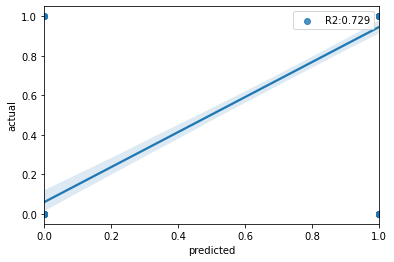

In [60]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

# StudLoan Pipeline

In [61]:
numeric_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Student_Loan_Interest(%)','Student_Loan_Interest_Payment','min_loan']
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

num_feats = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Student_Loan_Interest(%)','Student_Loan_Interest_Payment','min_loan']
cat_feats = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

In [62]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
])
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state = 42))
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
np.mean(preds == y_test)

0.944

In [63]:
fillna_step = ColumnTransformer([
    ('fillna_most_frequent', SimpleImputer(fill_value='missing',strategy="most_frequent"), cat_feats),
    ('fillna_mean', SimpleImputer(fill_value='missing',strategy="mean"), num_feats)
], remainder='passthrough')

from sklearn.preprocessing import OneHotEncoder
enc_cat = OneHotEncoder(handle_unknown='ignore', sparse=False)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

from sklearn.ensemble import GradientBoostingClassifier
model1 = RandomForestClassifier(n_estimators=100, max_depth=20,criterion='entropy')
pipeline = Pipeline(steps=[
    ('fillna_step',fillna_step),
    ('enc_cat',enc_cat),
    ('scaler',scaler),
    ('transformer',transformer),
    ('base_model',model1)
])
pipeline.fit(X,y)
pickle.dump(pipeline, open( "PipeRF_StudLoan.pkl", "wb" ) )

In [64]:
pipe = pipeline.fit(X, y)
print('Testing score: ', pipe.score(X, y))

Testing score:  0.8356713426853707


# Convential Dataframe 

In [65]:
con_df = pd.read_csv(r"data\CON_LOAN_DATA.csv")

In [66]:
con_df['min_loan'] = con_df['TotalIncome'] * con_df['RiskFreeRate(%)']

In [67]:
pd.set_option('display.max_columns', None)
con_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Loan_Interest,RiskFreeRate(%),STATUS,Default,Con_Loan_Interest(%),KellyCrit(%),TotalIncome,Con_Loan_Interest_Payment,min_loan
0,LP001002,1,0,0,0,0,5849,0.0,144,360.0,1.0,1,3,0.018,C,0,3.16,0.586709,5849.0,455.04,105.282
1,LP001003,1,1,1,0,0,4583,1508.0,128,360.0,1.0,0,3,0.018,X,2,3.16,0.586709,6091.0,404.48,109.638
2,LP001005,1,1,0,0,1,3000,0.0,66,360.0,1.0,1,3,0.018,X,2,3.16,0.586709,3000.0,208.56,54.000
3,LP001006,1,1,0,1,0,2583,2358.0,120,360.0,1.0,1,3,0.018,C,0,3.16,0.586709,4941.0,379.20,88.938
4,LP001008,1,0,0,0,0,6000,0.0,141,360.0,1.0,1,3,0.018,X,2,3.16,0.586709,6000.0,445.56,108.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,LP002978,0,0,0,0,0,2900,0.0,71,360.0,1.0,1,3,0.018,C,0,3.16,0.586709,2900.0,224.36,52.200
994,LP002979,1,1,3,0,0,4106,0.0,40,180.0,1.0,1,2,0.018,C,0,2.89,0.580796,4106.0,115.60,73.908
995,LP002983,1,1,1,0,0,8072,240.0,253,360.0,1.0,1,3,0.018,C,0,3.16,0.586709,8312.0,799.48,149.616
996,LP002984,1,1,2,0,0,7583,0.0,187,360.0,1.0,1,3,0.018,0,0,3.16,0.586709,7583.0,590.92,136.494


<AxesSubplot:xlabel='Loan_Status', ylabel='Count'>

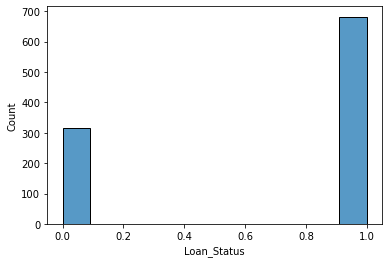

In [68]:
sns.histplot(con_df['Loan_Status'])

In [69]:
#Assign train and target variables
X = con_df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Interest','TotalIncome','Con_Loan_Interest(%)', 'Con_Loan_Interest_Payment', 'min_loan']]
y = con_df['Loan_Status']

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

In [70]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Random_Forest_Model_ConLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.807
MAE Score for test data:  0.04


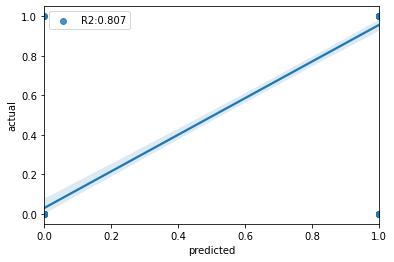

In [71]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

In [72]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [5,10,15,100,150,200,250],
    'criterion' : ['gini,', 'entropy'],
    'max_depth' : [5,8,10,12,15,18,20]
}

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Matthew Wong\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = sel

C:\Users\Matthew Wong\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.79005817 0.81014765 0.81148098 0.80882327 0.81014765
 0.81282327 0.81016555 0.81283221 0.8261745  0.82084116 0.83420134
 0.83151678 0.83152573 0.83151678 0.83288591 0.85156152 0.85964206
 0.8529217  0.8529217  0.85559732 0.85025503 0.85022819 0.87294855
 0.86763311 0.8756689  0.87032662 0.87298434 0

In [73]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 250}

0.9171096196868008

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
94,0.160952,0.002153,0.010654,0.000167,entropy,20,100,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.893333,0.94,0.920000,0.932886,0.899329,0.917110,0.018236,1
90,0.436713,0.061291,0.027604,0.009141,entropy,18,250,"{'criterion': 'entropy', 'max_depth': 18, 'n_e...",0.900000,0.94,0.913333,0.932886,0.899329,0.917110,0.016709,1
95,0.239348,0.001154,0.014054,0.000479,entropy,20,150,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.900000,0.94,0.920000,0.912752,0.906040,0.915758,0.013838,3


## Retrain Model

In [74]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=20,criterion='entropy')

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Final_Random_Forest_Model_ConLoan.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: 0.807
MAE Score for test data:  0.04


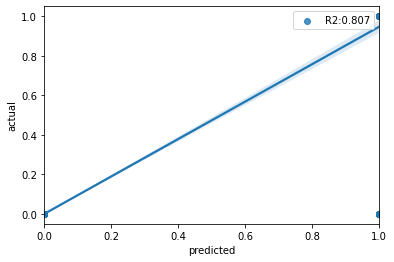

In [75]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

# StudLoan Pipeline

In [76]:
numeric_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Con_Loan_Interest(%)','Con_Loan_Interest_Payment','min_loan']
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

num_feats = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','Con_Loan_Interest(%)','Con_Loan_Interest_Payment','min_loan']
cat_feats = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Interest']

In [77]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
])
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state = 42))
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
np.mean(preds == y_test)

0.952

In [78]:
fillna_step = ColumnTransformer([
    ('fillna_most_frequent', SimpleImputer(fill_value='missing',strategy="most_frequent"), cat_feats),
    ('fillna_mean', SimpleImputer(fill_value='missing',strategy="mean"), num_feats)
], remainder='passthrough')

from sklearn.preprocessing import OneHotEncoder
enc_cat = OneHotEncoder(handle_unknown='ignore', sparse=False)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

from sklearn.ensemble import GradientBoostingClassifier
model1 = RandomForestClassifier(n_estimators=100, max_depth=20,criterion='entropy')
pipeline = Pipeline(steps=[
    ('fillna_step',fillna_step),
    ('enc_cat',enc_cat),
    ('scaler',scaler),
    ('transformer',transformer),
    ('base_model',model1)
])
pipeline.fit(X,y)
pickle.dump(pipeline, open( "PipeRF_ConLoan.pkl", "wb" ) )

In [79]:
pipe = pipeline.fit(X, y)
print('Testing score: ', pipe.score(X, y))

Testing score:  0.845691382765531
